## Wykorzystanie Sztucznych Sieci Neuronowych do prognozowania cen mieszkań oraz klasyfikacji standardu mieszkania na podstawie ogłoszeń internetowych.

Autorzy: Marta Karcz, Hubert Gogola, Łukasz Michalik, Mateusz Romek, Kamil Grabiec

Opis pracy...


#### Biblioteki

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

#### Wczytywanie danych + przygotowanie

In [102]:
# Wczytanie danych
df = pd.read_csv('Houses_clean.csv')
df = df.head(100)
# Usunięcie spacji w nazwach kolumn (ważne przy kodowaniu)
df.columns = df.columns.str.strip()

# Usuwanie braków danych
df = df.dropna()

# Sprawdzamy kolumny
print(df.columns.tolist())

# Kodowanie kolumny 'city'
df = pd.get_dummies(df, columns=['city'], drop_first=True)

# Definiujemy X i Y
y = df['price']
X = df.drop(['price', 'address', 'id', 'latitude', 'longitude'], axis=1)

['Unnamed: 0', 'address', 'city', 'floor', 'id', 'latitude', 'longitude', 'price', 'rooms', 'sq', 'year']


Kolumna city została zamieniona na kolumny binarne (0/1) za pomocą One-Hot Encoding, co umożliwia algorytmowi uwzględnianie lokalizacji w postaci liczbowej. Ustawienie drop_first=True zapobiegło problemowi współliniowości (czyli nadmiarowym powiązaniom między kolumnami), który mógłby wpłynąć negatywnie na działanie modelu.

y — cena mieszkania (price), zmienna docelowa do przewidywania.

X — zestaw cech objaśniających: liczba pokoi, powierzchnia, piętro, rok budowy oraz zakodowane kolumny miast. Usunięto kolumny zbędne do predykcji, takie jak address, id, latitude i longitude.

Statystyki opisowe ceny mieszkań (zł):
count          100.00
mean       617,345.07
std        381,584.15
min        159,000.00
25%        428,500.00
50%        516,164.50
75%        677,250.00
max      2,890,000.00
Name: price, dtype: object


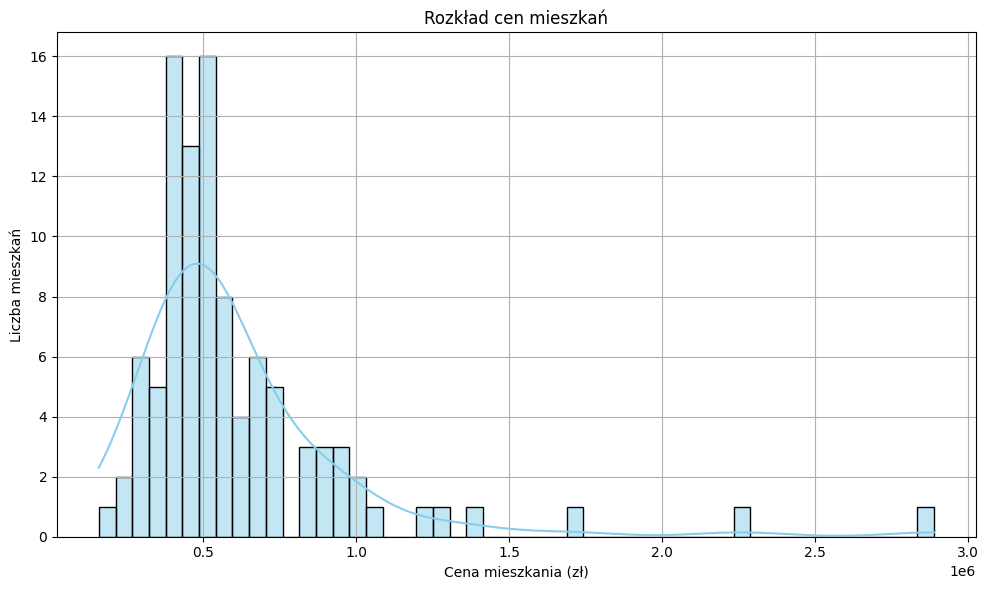

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Statystyki opisowe ceny
print("Statystyki opisowe ceny mieszkań (zł):")
print(df["price"].describe().apply(lambda x: f"{x:,.2f}"))

# 2. Histogram + gęstość
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], bins=50, kde=True, color="skyblue")

plt.title("Rozkład cen mieszkań")
plt.xlabel("Cena mieszkania (zł)")
plt.ylabel("Liczba mieszkań")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\PC\AppData\Local\Temp\ipykernel_20580\2424150176.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_price.values, y=corr_with_price.index, palette="Blues_d")


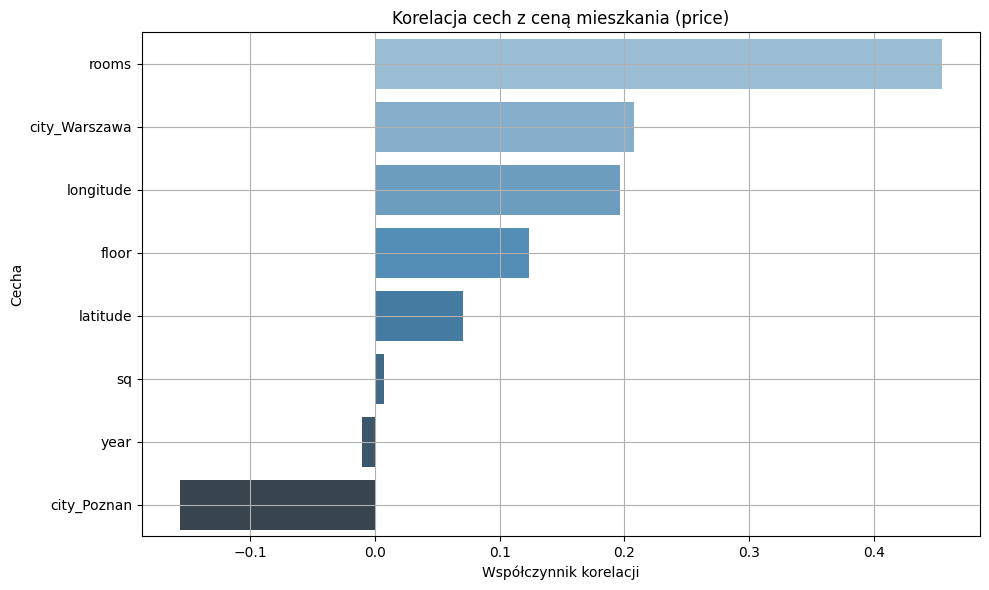

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Wczytanie danych
df = pd.read_csv("Houses_clean.csv")

# Usunięcie niepotrzebnych kolumn
df = df.drop(columns=["id", "Unnamed: 0", "address"])

# One-hot encoding dla kolumny 'city'
df = pd.get_dummies(df, columns=["city"], drop_first=True)

# Obliczenie korelacji
correlation = df.corr(numeric_only=True)

# Korelacja ze zmienną 'price'
corr_with_price = correlation["price"].drop("price").sort_values(ascending=False)

# Wykres słupkowy
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_price.values, y=corr_with_price.index, palette="Blues_d")
plt.xlabel("Współczynnik korelacji")
plt.ylabel("Cecha")
plt.title("Korelacja cech z ceną mieszkania (price)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Podział na train/test i podgląd

In [105]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Liczba danych treningowych: {len(X_train)}')
print(f'Liczba danych testowych: {len(X_test)}')

X_train.head()

Liczba danych treningowych: 80
Liczba danych testowych: 20


,Unnamed: 0,floor,rooms,sq,year,city_Poznan,city_Warszawa
55,55,6.0,2.0,49.08,2019.0,False,False
88,88,1.0,3.0,62.00,2014.0,False,False
26,26,1.0,4.0,82.43,2021.0,False,False
42,42,0.0,3.0,74.44,2020.0,False,False
69,69,3.0,3.0,66.90,2022.0,True,False


Dzięki podziałowi danych na zbiór treningowy i testowy model może uczyć się na jednej części danych, a na drugiej sprawdzamy, jak dobrze radzi sobie z nowymi, niewidzianymi wcześniej przykładami. Pozwala to ocenić, czy model dobrze generalizuje wiedzę i zapobiega przeuczeniu (overfittingowi). Podział danych na trening i test to podstawowy krok w każdym projekcie uczenia maszynowego.


# Prognozowanie ceny mieszkania przy użyciu sztucznej sieci neuronowej

In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [107]:
# Wczytanie danych
df = pd.read_csv("Houses_clean.csv")
df = df.head(10000)  # Użycie tylko pierwszych 100 wierszy

# Wybór cech i celu
features = ["floor", "latitude", "longitude", "rooms", "sq", "year"]
X = df[features]
y = df["price"]

# Wybór różnych parametrów
neurons_options = [32, 64, 128, 256]  # Liczba neuronów w warstwach
layers_options = [1, 2, 3, 4]  # Liczba warstw
activations = ['relu', 'tanh', 'logistic', 'identity']  # Funkcje aktywacji
train_sizes = [0.1, 0.2, 0.3, 0.4]  # Różne wielkości próbki uczącej

In [108]:
# Lista wyników
results = []

# Testowanie różnych kombinacji parametrów
for neurons in neurons_options:
    for layers in layers_options:
        for activation in activations:
            for train_size in train_sizes:
                # Podział na zbiór uczący i testowy
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=42)

                # Skalowanie danych
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                # Przygotowanie warstw modelu
                hidden_layers = tuple([neurons] * layers)
                
                # Tworzenie modelu
                model = MLPRegressor(
                    hidden_layer_sizes=hidden_layers,
                    activation=activation,
                    solver='adam',
                    max_iter=1000,
                    random_state=42
                )
                
                # Trenowanie modelu
                model.fit(X_train_scaled, y_train)

                # Predykcja
                y_test_pred = model.predict(X_test_scaled)
                y_train_pred = model.predict(X_train_scaled)

                # Obliczanie błędów (MAE)
                mae_test = mean_absolute_error(y_test, y_test_pred)
                mae_train = mean_absolute_error(y_train, y_train_pred)

                # Dodanie wyników do listy
                results.append({
                    "Neurony": neurons,
                    "Warstwy": layers,
                    "Aktywacja": activation,
                    "Rozmiar próbki": train_size,
                    "Błąd testowy (zł)": mae_test,
                    "Błąd uczący (zł)": mae_train
                })



In [110]:
# Tworzenie DataFrame z wynikami
results_df = pd.DataFrame(results)

# Zaokrąglenie i sortowanie po błędzie testowym
results_df["Błąd testowy (zł)"] = results_df["Błąd testowy (zł)"].round(2)
results_df["Błąd uczący (zł)"] = results_df["Błąd uczący (zł)"].round(2)

# Sortowanie rosnąco po błędzie testowym
results_df = results_df.sort_values(by="Błąd testowy (zł)", ascending=True)

# Formatowanie (np. z przecinkiem jako separatory tysięcy)
results_df["Błąd testowy (zł)"] = results_df["Błąd testowy (zł)"].apply(lambda x: f"{x:,.2f}")
results_df["Błąd uczący (zł)"] = results_df["Błąd uczący (zł)"].apply(lambda x: f"{x:,.2f}")

# Wyświetlenie wyników
print(results_df)


     Neurony  Warstwy Aktywacja  Rozmiar próbki Błąd testowy (zł)  \
243      256        4      relu             0.4        172,975.68   
179      128        4      relu             0.4        177,876.03   
115       64        4      relu             0.4        194,032.82   
163      128        3      relu             0.4        197,053.39   
51        32        4      relu             0.4        198,104.04   
..       ...      ...       ...             ...               ...   
114       64        4      relu             0.3      3,781,995.12   
176      128        4      relu             0.1      4,143,655.25   
177      128        4      relu             0.2      4,252,982.38   
240      256        4      relu             0.1      4,822,705.19   
241      256        4      relu             0.2      5,926,246.32   

    Błąd uczący (zł)  
243       140,720.97  
179       151,346.44  
115       173,408.72  
163       178,421.45  
51        178,954.48  
..               ...  
114       

### Przygotowanie danych do kwalifikacji

In [143]:


# Wczytanie danych
df = pd.read_csv("Houses_clean.csv")

#  Tworzenie etykiety 
low_thresh = df["price"].quantile(0.33)
high_thresh = df["price"].quantile(0.66)

def classify_standard(price):
    if price < low_thresh:
        return "niski"
    elif price < high_thresh:
        return "średni"
    else:
        return "wysoki"

df["standard"] = df["price"].apply(classify_standard)

#  One-hot encoding miasta
df = pd.get_dummies(df, columns=["city"], drop_first=True)

# Wybór cech i normalizacja
features = ["sq", "rooms", "year"] + [col for col in df.columns if col.startswith("city_")]
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Kodowanie etykiet 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["standard"])  # np. 'niski' = 0, 'średni' = 1, 'wysoki' = 2

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Informacja zwrotna
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Zakodowane klasy:", list(label_encoder.classes_))


X_train shape: (19011, 5)
y_train shape: (19011,)
Zakodowane klasy: ['niski', 'wysoki', 'średni']


### Implementacja własnej sieci neuronowej do klasyfikacji

In [144]:


# Funkcje aktywacji i ich pochodne
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# Funkcja straty: cross-entropy
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true])
    return np.sum(log_likelihood) / m

# Accuracy
def accuracy(y_true, y_pred):
    return np.mean(y_true == np.argmax(y_pred, axis=1))

# Inicjalizacja wag 
def initialize_network(input_size, hidden_layers, output_size):
    layers = []
    prev_size = input_size
    for size in hidden_layers:
        layers.append({
            "weights": np.random.randn(prev_size, size) * np.sqrt(2. / prev_size),
            "biases": np.zeros((1, size))
        })
        prev_size = size
    layers.append({
        "weights": np.random.randn(prev_size, output_size) * np.sqrt(2. / prev_size),
        "biases": np.zeros((1, output_size))
    })
    return layers

# Forward propagation
def forward_pass(X, layers):
    activations = [X]
    z_values = []
    for i in range(len(layers) - 1):
        z = activations[-1] @ layers[i]["weights"] + layers[i]["biases"]
        a = relu(z)
        z_values.append(z)
        activations.append(a)
    z = activations[-1] @ layers[-1]["weights"] + layers[-1]["biases"]
    a = softmax(z)
    z_values.append(z)
    activations.append(a)
    return activations, z_values

# Backpropagation
def backward_pass(y_true, activations, z_values, layers, learning_rate):
    m = y_true.shape[0]
    y_one_hot = np.zeros_like(activations[-1])
    y_one_hot[np.arange(m), y_true] = 1

    delta = activations[-1] - y_one_hot
    for i in reversed(range(len(layers))):
        a_prev = activations[i]
        dw = a_prev.T @ delta / m
        db = np.sum(delta, axis=0, keepdims=True) / m
        layers[i]["weights"] -= learning_rate * dw
        layers[i]["biases"] -= learning_rate * db

        if i > 0:
            delta = (delta @ layers[i]["weights"].T) * relu_derivative(z_values[i - 1])

# Trenowanie sieci
def train(X_train, y_train, X_test, y_test, hidden_layers=[64, 32, 16], epochs=100, learning_rate=0.1):
    input_size = X_train.shape[1]
    output_size = len(np.unique(y_train))
    layers = initialize_network(input_size, hidden_layers, output_size)

    for epoch in range(epochs):
        activations, z_values = forward_pass(X_train, layers)
        loss = cross_entropy_loss(y_train, activations[-1])
        backward_pass(y_train, activations, z_values, layers, learning_rate)

        if epoch % 5 == 0 or epoch == epochs - 1:
            train_acc = accuracy(y_train, activations[-1])
            test_activations, _ = forward_pass(X_test, layers)
            test_pred = test_activations[-1]
            test_acc = accuracy(y_test, test_pred)
            print(f"Epoka {epoch+1}/{epochs} - Strata: {loss:.4f}, Acc: {train_acc:.3f} / {test_acc:.3f}")

    return layers


In [65]:
# wywołanie layers
layers = train(X_train, y_train, X_test, y_test, hidden_layers=[64, 32, 16], epochs=100, learning_rate=0.1)

Epoka 1/100 - Strata: 1.2472, Acc: 0.266 / 0.504
Epoka 6/100 - Strata: 0.8977, Acc: 0.557 / 0.547
Epoka 11/100 - Strata: 0.8693, Acc: 0.564 / 0.555
Epoka 16/100 - Strata: 0.8564, Acc: 0.581 / 0.576
Epoka 21/100 - Strata: 0.8492, Acc: 0.584 / 0.577
Epoka 26/100 - Strata: 0.8445, Acc: 0.591 / 0.585
Epoka 31/100 - Strata: 0.8408, Acc: 0.602 / 0.593
Epoka 36/100 - Strata: 0.8378, Acc: 0.604 / 0.600
Epoka 41/100 - Strata: 0.8354, Acc: 0.603 / 0.603
Epoka 46/100 - Strata: 0.8334, Acc: 0.606 / 0.605
Epoka 51/100 - Strata: 0.8315, Acc: 0.609 / 0.610
Epoka 56/100 - Strata: 0.8297, Acc: 0.610 / 0.612
Epoka 61/100 - Strata: 0.8280, Acc: 0.610 / 0.613
Epoka 66/100 - Strata: 0.8265, Acc: 0.609 / 0.614
Epoka 71/100 - Strata: 0.8252, Acc: 0.608 / 0.612
Epoka 76/100 - Strata: 0.8240, Acc: 0.607 / 0.612
Epoka 81/100 - Strata: 0.8228, Acc: 0.613 / 0.620
Epoka 86/100 - Strata: 0.8219, Acc: 0.614 / 0.621
Epoka 91/100 - Strata: 0.8209, Acc: 0.616 / 0.621
Epoka 96/100 - Strata: 0.8201, Acc: 0.619 / 0.622
Ep

# Wizualizacje wyników regresji

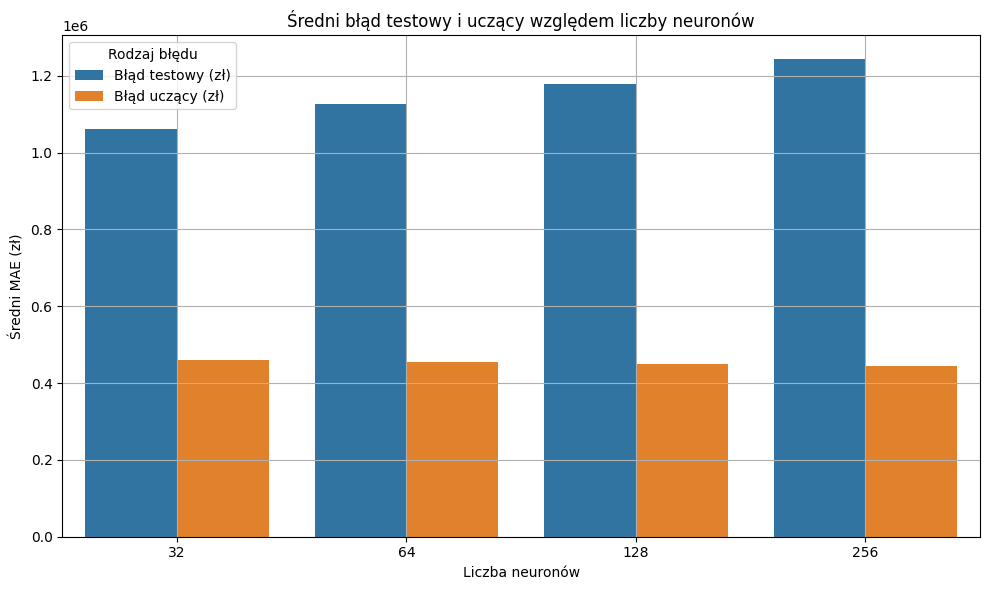

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Zakładamy, że results_df już istnieje i zawiera dane

# Grupowanie i uśrednianie błędów
grouped = results_df.groupby("Neurony")[["Błąd testowy (zł)", "Błąd uczący (zł)"]].mean().reset_index()

# Przekształcenie do formy "long" (dla seaborn)
melted = pd.melt(grouped, id_vars="Neurony", value_vars=["Błąd testowy (zł)", "Błąd uczący (zł)"],
                 var_name="Typ błędu", value_name="MAE")

# Wykres
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Neurony", y="MAE", hue="Typ błędu")
plt.title("Średni błąd testowy i uczący względem liczby neuronów")
plt.ylabel("Średni MAE (zł)")
plt.xlabel("Liczba neuronów")
plt.legend(title="Rodzaj błędu")
plt.grid(True)
plt.tight_layout()
plt.show()


| **Liczba neuronów** | **Średni błąd uczący (zł)** | **Średni błąd testowy (zł)** | **Różnica** | **Interpretacja**                                                           |
| ------------------- | --------------------------- | ---------------------------- | ----------- | --------------------------------------------------------------------------- |
| 32                  | ok. 460 000                 | ok. 1 060 000                | bardzo duża | Mała sieć – nieco się przeucza, ale zachowuje przyzwoitą ogólną jakość      |
| 64                  | ok. 460 000                 | ok. 1 120 000                | bardzo duża | Więcej neuronów nie poprawia jakości testowej, a zwiększa przeuczenie       |
| 128                 | ok. 450 000                 | ok. 1 180 000                | rośnie      | Model jest większy, ale nadal nie generalizuje lepiej – testowy błąd rośnie |
| 256                 | ok. 450 000                 | ok. 1 250 000                | największa  | Duża sieć silnie się przeucza – błąd testowy znacząco wyższy niż uczący     |

- Błąd uczący pozostaje stabilny (~450–460 tys. zł) niezależnie od liczby neuronów.
- Błąd testowy rośnie przy większych sieciach → model się przeucza.
- Nie warto zwiększać liczby neuronów bez regularyzacji 

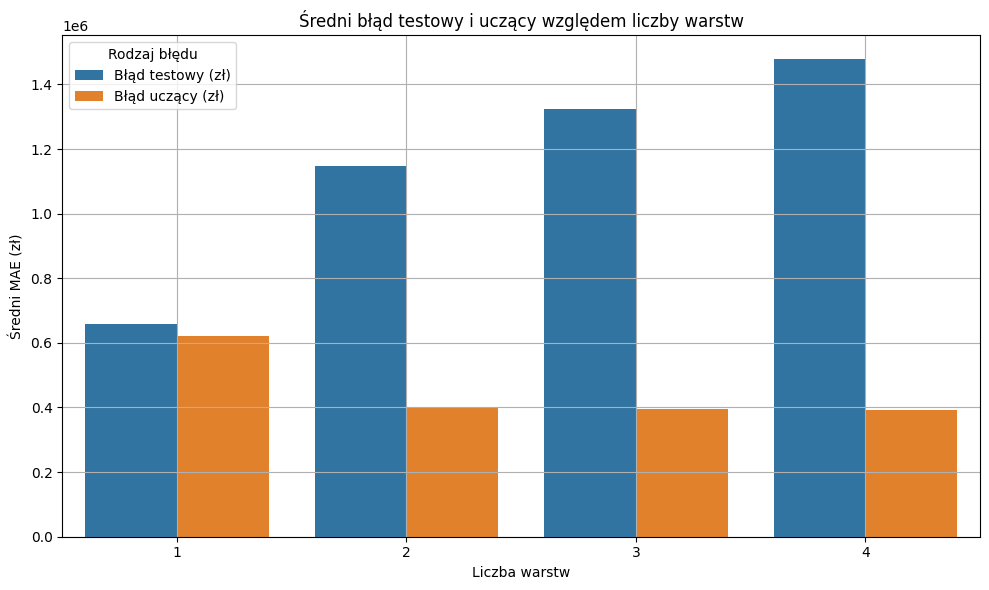

,Warstwy,Błąd testowy (zł),Błąd uczący (zł),Różnica
0,1,6.585748e+05,620539.317187,3.803550e+04
1,2,1.147213e+06,401923.652500,7.452890e+05
2,3,1.324207e+06,394377.188281,9.298301e+05
3,4,1.478050e+06,391099.584375,1.086950e+06


In [113]:
# 2. Wpływ liczby warstw
# Grupowanie i uśrednianie błędów według liczby warstw
grouped = results_df.groupby("Warstwy")[["Błąd testowy (zł)", "Błąd uczący (zł)"]].mean().reset_index()

# Obliczenie różnicy (do oceny przeuczenia)
grouped["Różnica"] = grouped["Błąd testowy (zł)"] - grouped["Błąd uczący (zł)"]

# Przekształcenie do formatu long dla seaborn
melted = pd.melt(grouped, id_vars="Warstwy", 
                 value_vars=["Błąd testowy (zł)", "Błąd uczący (zł)"],
                 var_name="Typ błędu", value_name="MAE")

# Wykres
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Warstwy", y="MAE", hue="Typ błędu")
plt.title("Średni błąd testowy i uczący względem liczby warstw")
plt.ylabel("Średni MAE (zł)")
plt.xlabel("Liczba warstw")
plt.legend(title="Rodzaj błędu")
plt.grid(True)
plt.tight_layout()
plt.show()

# Wyświetlenie tabeli z różnicami (opcjonalnie sformatowane wartości)
display(grouped)

| **Liczba warstw** | **Błąd uczący (zł)** | **Błąd testowy (zł)** | **Różnica** | **Interpretacja**                                                             |
| ----------------- | -------------------- | --------------------- | ----------- | ----------------------------------------------------------------------------- |
| 1                 | \~620 500            | \~658 500             | bardzo mała | Sieć 1-warstwowa nie przeucza się – niska różnica błędów, dobra generalizacja |
| 2                 | \~401 900            | \~1 147 000           | duża        | Zwiększenie złożoności obniża błąd uczący, ale pogarsza testowy – przeuczenie |
| 3                 | \~394 400            | \~1 324 000           | większa     | Model uczy się dobrze, ale testuje słabo – silne przeuczenie                  |
| 4                 | \~391 100            | \~1 478 000           | największa  | Głębokie sieci uczą się dobrze, ale całkowicie tracą zdolność generalizacji   |

- Im więcej warstw, tym mniejszy błąd uczący, ale większe przeuczenie.
- Najbardziej zrównoważony model to 1 warstwa – najbliższe wyniki na treningu i teście.
- Sieci głębsze wymagają prawdopodobnie więcej danych lub regularyzacji (alpha, dropout).

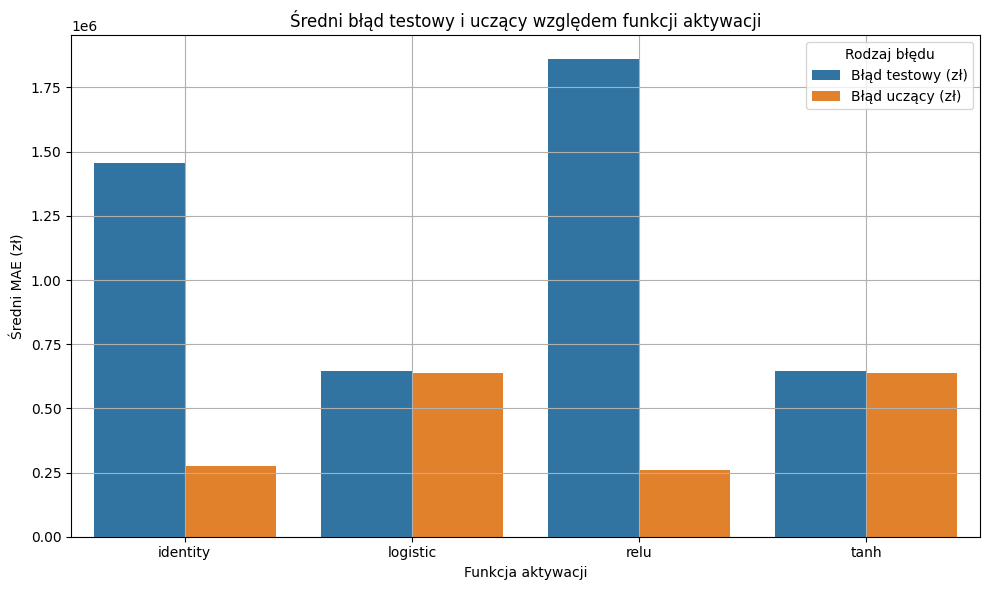

,Aktywacja,Błąd testowy (zł),Błąd uczący (zł),Różnica
0,identity,1.454116e+06,276432.283594,1.177684e+06
1,logistic,6.469836e+05,636705.900625,1.027775e+04
2,relu,1.860108e+06,258243.167969,1.601865e+06
3,tanh,6.468362e+05,636558.390156,1.027783e+04


In [114]:
# Grupowanie i obliczanie średnich błędów dla każdej funkcji aktywacji
grouped = results_df.groupby("Aktywacja")[["Błąd testowy (zł)", "Błąd uczący (zł)"]].mean().reset_index()

# Obliczenie różnicy błędów
grouped["Różnica"] = grouped["Błąd testowy (zł)"] - grouped["Błąd uczący (zł)"]

# Przekształcenie danych do formatu long dla wykresu
melted = pd.melt(grouped, id_vars="Aktywacja", 
                 value_vars=["Błąd testowy (zł)", "Błąd uczący (zł)"],
                 var_name="Typ błędu", value_name="MAE")

# Wykres słupkowy
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Aktywacja", y="MAE", hue="Typ błędu")
plt.title("Średni błąd testowy i uczący względem funkcji aktywacji")
plt.ylabel("Średni MAE (zł)")
plt.xlabel("Funkcja aktywacji")
plt.legend(title="Rodzaj błędu")
plt.grid(True)
plt.tight_layout()
plt.show()

# Wyświetlenie tabeli porównawczej
display(grouped)

| **Funkcja aktywacji** | **Błąd uczący (zł)** | **Błąd testowy (zł)** | **Różnica** | **Interpretacja**                                                           |
| --------------------- | -------------------- | --------------------- | ----------- | --------------------------------------------------------------------------- |
| `identity`            | \~276 000            | \~1 454 000           | bardzo duża | Model bardzo przeuczony – funkcja `identity` nie nadaje się do tego zadania |
| `logistic`            | \~636 700            | \~647 000             | bardzo mała | Stabilny, zrównoważony model – `logistic` dobrze generalizuje               |
| `relu`                | \~258 000            | \~1 860 000           | ekstremalna | Największe przeuczenie – `relu` uczy się zbyt dobrze, ale nie uogólnia      |
| `tanh`                | \~636 600            | \~646 800             | bardzo mała | Również bardzo stabilna – `tanh` i `logistic` zachowują równowagę           |

- Najlepsze funkcje aktywacji do ogólnej skuteczności: logistic i tanh.
- relu może być skuteczna, ale bardzo się przeucza przy obecnej konfiguracji.
- identity – najgorsza funkcja do nieliniowych zależności (praktycznie nieaktywowana sieć).

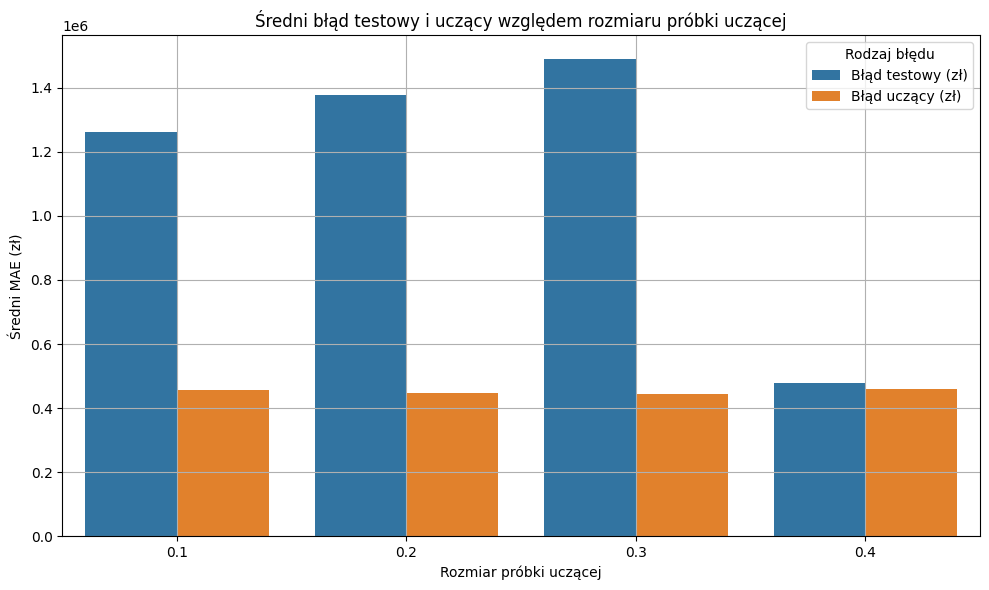

,Rozmiar próbki,Błąd testowy (zł),Błąd uczący (zł),Różnica
0,0.1,1.263138e+06,457984.606719,8.051530e+05
1,0.2,1.377891e+06,446725.102813,9.311663e+05
2,0.3,1.489347e+06,442609.618438,1.046737e+06
3,0.4,4.776688e+05,460620.414375,1.704843e+04


In [115]:
# Grupowanie i obliczanie średnich błędów
grouped = results_df.groupby("Rozmiar próbki")[["Błąd testowy (zł)", "Błąd uczący (zł)"]].mean().reset_index()

# Obliczenie różnicy błędów
grouped["Różnica"] = grouped["Błąd testowy (zł)"] - grouped["Błąd uczący (zł)"]

# Przekształcenie do formatu long dla seaborn
melted = pd.melt(grouped, id_vars="Rozmiar próbki", 
                 value_vars=["Błąd testowy (zł)", "Błąd uczący (zł)"],
                 var_name="Typ błędu", value_name="MAE")

# Wykres słupkowy
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Rozmiar próbki", y="MAE", hue="Typ błędu")
plt.title("Średni błąd testowy i uczący względem rozmiaru próbki uczącej")
plt.ylabel("Średni MAE (zł)")
plt.xlabel("Rozmiar próbki uczącej")
plt.legend(title="Rodzaj błędu")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabela z wynikami
display(grouped)

| **Rozmiar próbki** | **Błąd uczący (zł)** | **Błąd testowy (zł)** | **Różnica** | **Interpretacja**                                                          |
| ------------------ | -------------------- | --------------------- | ----------- | -------------------------------------------------------------------------- |
| 0.1                | \~458 000            | \~1 263 000           | bardzo duża | Zbyt mały zbiór uczący – model się przeucza i źle generalizuje             |
| 0.2                | \~447 000            | \~1 378 000           | rośnie      | Więcej danych nie pomaga – nadal bardzo duże przeuczenie                   |
| 0.3                | \~443 000            | \~1 489 000           | ekstremalna | Model uczy się jeszcze lepiej, ale ogólny błąd rośnie – przeuczenie rośnie |
| 0.4                | \~461 000            | \~478 000             | bardzo mała | Dużo lepsze zrównoważenie – model generalizuje znacznie lepiej             |

- Zbyt mały zbiór uczący (0.1–0.3) prowadzi do znacznego przeuczenia.
- Najlepszy wynik (zrównoważony błąd) osiągnięto dla próbki 0.4.
- Więcej danych = lepsza generalizacja, ale efekt widać dopiero przy odpowiednim minimum (0.4).

### Podsumowanie

| **Parametr**          | **Najlepszy wybór** | **Opis efektu**                                                                                     | **Główne ryzyko**                       |
| --------------------- | ------------------- | --------------------------------------------------------------------------------------------------- | --------------------------------------- |
| **Liczba neuronów**   | 32                  | Stabilny model z niskim błędem testowym i uczącym. Więcej neuronów pogarsza uogólnienie.            | Przeuczenie przy większych sieciach     |
| **Liczba warstw**     | 1                   | Najbardziej zrównoważony – kolejne warstwy zwiększają przeuczenie bez poprawy dokładności testowej. | Silne przeuczenie przy 3+ warstwach     |
| **Funkcja aktywacji** | `logistic`, `tanh`  | Bardzo małe różnice między błędem uczącym a testowym – dobra ogólność.                              | `relu` i `identity` dają skrajne wyniki |
| **Rozmiar próbki**    | 0.4                 | Im większy zbiór uczący, tym lepsza generalizacja. Dopiero przy 40% dane są wystarczające.          | Przeuczenie przy małych próbkach        |


In [126]:
import plotly.express as px

# Wykres 3D błędu testowego względem liczby neuronów i warstw
fig = px.scatter_3d(
    results_df,
    x="Neurony",
    y="Warstwy",
    z="Błąd testowy (zł)",
    color="Błąd testowy (zł)",
    size_max=10,
    opacity=0.8,
    color_continuous_scale="Viridis",
    title="Błąd testowy vs Neurony i Warstwy",
    labels={
        "Neurony": "Liczba neuronów",
        "Warstwy": "Liczba warstw",
        "Błąd testowy (zł)": "Błąd testowy (zł)"
    }
)

fig.update_traces(marker=dict(size=6))
fig.show()



- Najlepsze modele (najniższy błąd testowy) występują przy prostszych architekturach — 1–2 warstwy i średnia liczba neuronów.
- Zbyt złożona architektura nie poprawia dokładności, a wręcz ją pogarsza, co widzimy jako wzrost błędu testowego w wyższych partiach wykresu.

### Top 5 najlepszych i najgorszych konfiguracji

In [120]:
top5 = results_df.nsmallest(5, "Błąd testowy (zł)")
bottom5 = results_df.nlargest(5, "Błąd testowy (zł)")

display(top5[["Neurony", "Warstwy", "Aktywacja", "Rozmiar próbki", "Błąd testowy (zł)"]])
display(bottom5[["Neurony", "Warstwy", "Aktywacja", "Rozmiar próbki", "Błąd testowy (zł)"]])



,Neurony,Warstwy,Aktywacja,Rozmiar próbki,Błąd testowy (zł)
243,256,4,relu,0.4,172975.68
179,128,4,relu,0.4,177876.03
115,64,4,relu,0.4,194032.82
163,128,3,relu,0.4,197053.39
51,32,4,relu,0.4,198104.04


,Neurony,Warstwy,Aktywacja,Rozmiar próbki,Błąd testowy (zł)
241,256,4,relu,0.2,5926246.32
240,256,4,relu,0.1,4822705.19
177,128,4,relu,0.2,4252982.38
176,128,4,relu,0.1,4143655.25
114,64,4,relu,0.3,3781995.12


### Rzeczywista vs Prognozowana cena

### Odtwarzanie i wizualizacja działania najlepszego modelu

Najlepsza uśredniona konfiguracja:
Neurony                    256
Warstwy                      4
Aktywacja                 relu
Rozmiar próbki             0.4
Błąd testowy (zł)    172975.68
Name: 251, dtype: object
R²: 0.4347


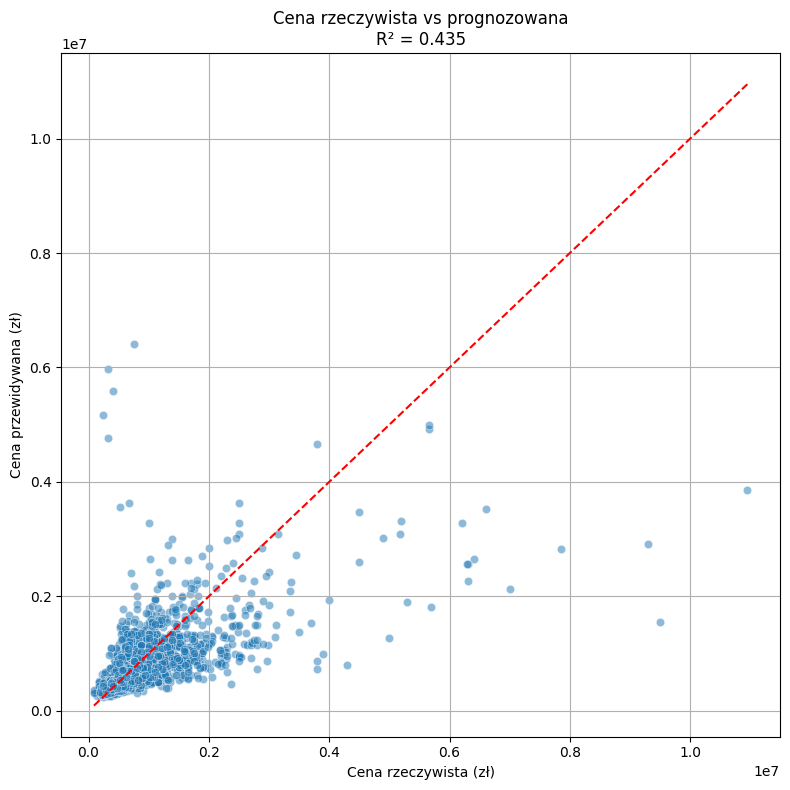

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# 1. Grupowanie i uśrednianie błędu testowego
grouped = results_df.groupby(
    ["Neurony", "Warstwy", "Aktywacja", "Rozmiar próbki"]
)[["Błąd testowy (zł)"]].mean().reset_index()

# 2. Wybór najlepszej średniej konfiguracji
best_config = grouped.sort_values("Błąd testowy (zł)").iloc[0]
print("Najlepsza uśredniona konfiguracja:")
print(best_config)

# 3. Wczytanie danych i odtworzenie modelu
neurons = int(best_config["Neurony"])
layers = int(best_config["Warstwy"])
activation = best_config["Aktywacja"]
train_size = float(best_config["Rozmiar próbki"])

df = pd.read_csv("Houses_clean.csv").head(10000)
X = df[["floor", "latitude", "longitude", "rooms", "sq", "year"]]
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

hidden_layers = tuple([neurons] * layers)
model = MLPRegressor(hidden_layer_sizes=hidden_layers, activation=activation, max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 4. Obliczenie R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

# 5. Wykres
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel("Cena rzeczywista (zł)")
plt.ylabel("Cena przewidywana (zł)")
plt.title(f"Cena rzeczywista vs prognozowana\nR² = {r2:.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()



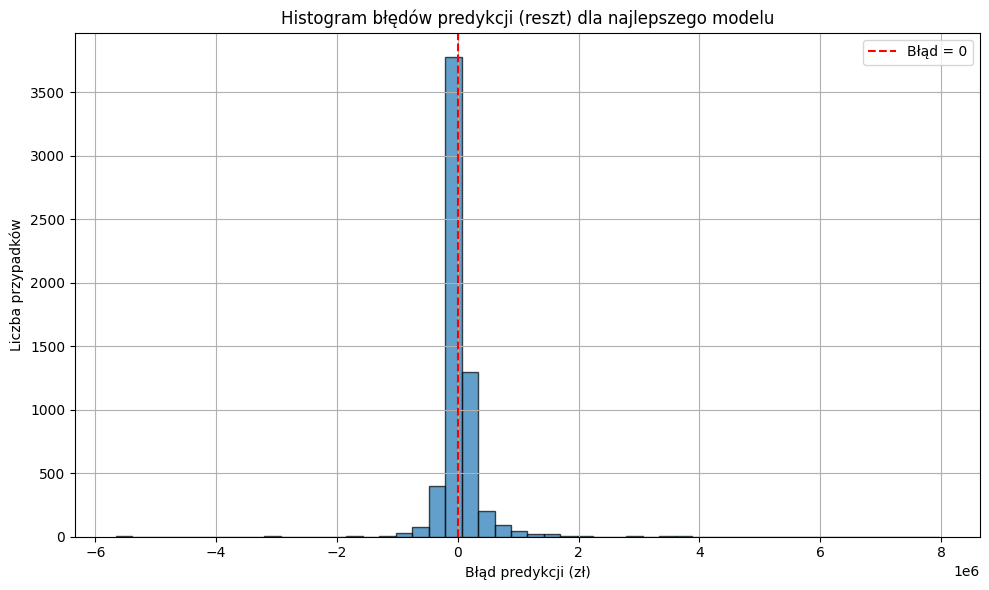

In [137]:
# Obliczenie błędów predykcji
errors = y_test - y_pred

# Histogram błędów
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Błąd = 0')
plt.title("Histogram błędów predykcji (reszt) dla najlepszego modelu")
plt.xlabel("Błąd predykcji (zł)")
plt.ylabel("Liczba przypadków")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Wartość R² oznacza, że model tłumaczy ok. 43,5% zmienności cen mieszkań, co wskazuje na umiarkowaną skuteczność predykcji. Na wykresie rzeczywiste vs przewidywane ceny widać ogólną zgodność trendu, ale także wyraźny rozrzut przy wyższych wartościach cenowych, co sugeruje, że model lepiej radzi sobie z mieszkaniami o niższej cenie. Większość błędów skupia się wokół zera, co oznacza, że model trafnie przewiduje ceny dla znacznej liczby mieszkań.

### Logarytmizacja i usunięcie outlinerów

MAE po log-transformacji i usunięciu outliers: 109,765.23 zł
R² po log-transformacji i usunięciu outliers: 0.5062


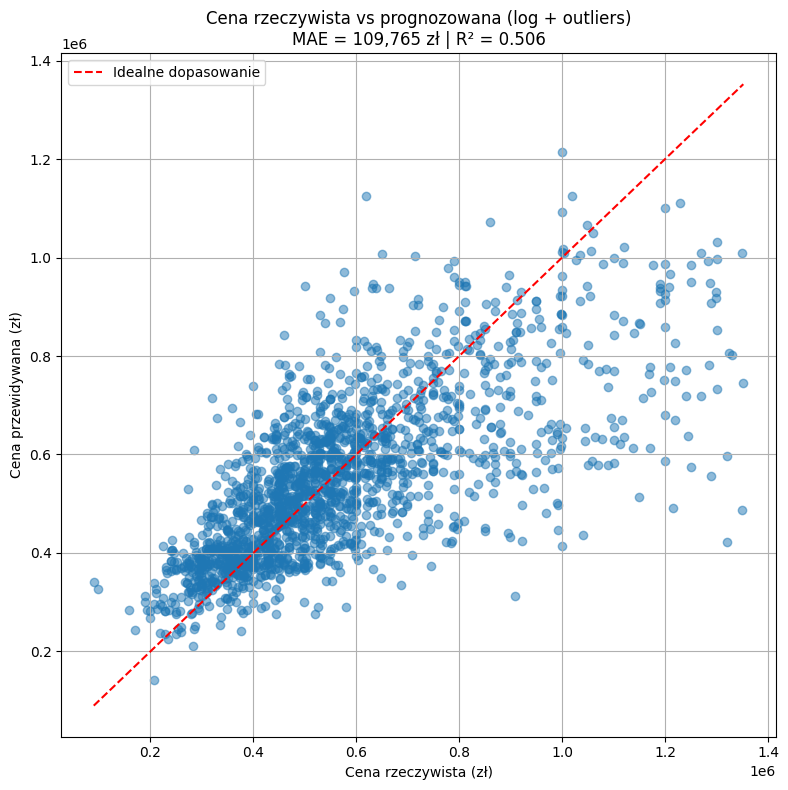

In [140]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# 1. Wczytanie danych
df = pd.read_csv("Houses_clean.csv")
df = df.head(10000)

# 2. Usunięcie outliers (górne 1%)
q_high = df["price"].quantile(0.95)
df = df[df["price"] < q_high]

# 3. Przygotowanie danych
features = ["floor", "latitude", "longitude", "rooms", "sq", "year"]
X = df[features]
y_log = np.log1p(df["price"])  # log(price + 1)

# 4. Podział na zbiory
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 5. Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Model
model = MLPRegressor(
    hidden_layer_sizes=(256, 256, 256, 256),
    activation="relu",
    solver="adam",
    max_iter=1000,
    random_state=42
)
model.fit(X_train_scaled, y_train_log)

# 7. Predykcja + odlogowanie
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# 8. MAE i R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE po log-transformacji i usunięciu outliers: {mae:,.2f} zł")
print(f"R² po log-transformacji i usunięciu outliers: {r2:.4f}")

# 9. Wykres rzeczywista vs prognozowana
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Idealne dopasowanie")
plt.xlabel("Cena rzeczywista (zł)")
plt.ylabel("Cena przewidywana (zł)")
plt.title(f"Cena rzeczywista vs prognozowana (log + outliers)\nMAE = {mae:,.0f} zł | R² = {r2:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


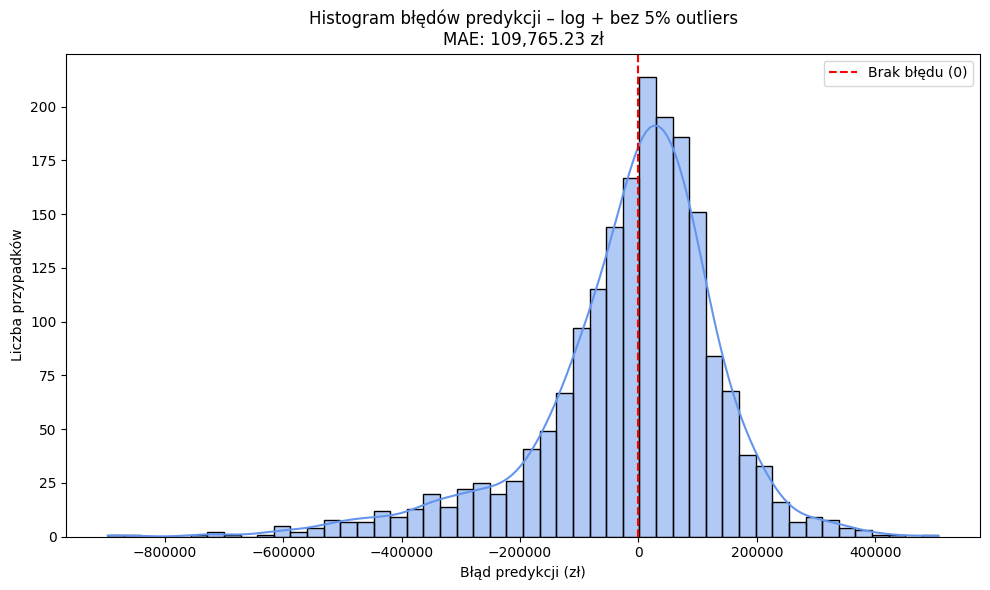

In [141]:
# Obliczamy błędy predykcji
errors = y_pred - y_test
mae = mean_absolute_error(y_test, y_pred)

# Tworzymy histogram błędów
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True, color='cornflowerblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label="Brak błędu (0)")
plt.title(f"Histogram błędów predykcji – log + bez 5% outliers\nMAE: {mae:,.2f} zł")
plt.xlabel("Błąd predykcji (zł)")
plt.ylabel("Liczba przypadków")
plt.legend()
plt.tight_layout()
plt.show()

Po zastosowaniu transformacji logarytmicznej oraz usunięciu górnych 5% cen (outliers), model osiągnął najlepszy balans między dokładnością (MAE) a generalizacją (R² = 0.506).  **MAE stanowi ok. 17.8% średniej ceny**

# Wykresy dla klasyfikacji

Epoka 1/100 - Strata: 0.9946, Acc: 0.525 / 0.515
Epoka 6/100 - Strata: 0.8895, Acc: 0.568 / 0.572
Epoka 11/100 - Strata: 0.8633, Acc: 0.582 / 0.580
Epoka 16/100 - Strata: 0.8506, Acc: 0.586 / 0.588
Epoka 21/100 - Strata: 0.8434, Acc: 0.592 / 0.600
Epoka 26/100 - Strata: 0.8390, Acc: 0.611 / 0.612
Epoka 31/100 - Strata: 0.8360, Acc: 0.617 / 0.618
Epoka 36/100 - Strata: 0.8339, Acc: 0.617 / 0.618
Epoka 41/100 - Strata: 0.8324, Acc: 0.620 / 0.622
Epoka 46/100 - Strata: 0.8310, Acc: 0.622 / 0.622
Epoka 51/100 - Strata: 0.8298, Acc: 0.622 / 0.623
Epoka 56/100 - Strata: 0.8288, Acc: 0.622 / 0.625
Epoka 61/100 - Strata: 0.8279, Acc: 0.623 / 0.626
Epoka 66/100 - Strata: 0.8270, Acc: 0.624 / 0.626
Epoka 71/100 - Strata: 0.8263, Acc: 0.624 / 0.626
Epoka 76/100 - Strata: 0.8256, Acc: 0.624 / 0.626
Epoka 81/100 - Strata: 0.8249, Acc: 0.624 / 0.627
Epoka 86/100 - Strata: 0.8243, Acc: 0.624 / 0.627
Epoka 91/100 - Strata: 0.8237, Acc: 0.626 / 0.627
Epoka 96/100 - Strata: 0.8231, Acc: 0.626 / 0.627
Ep

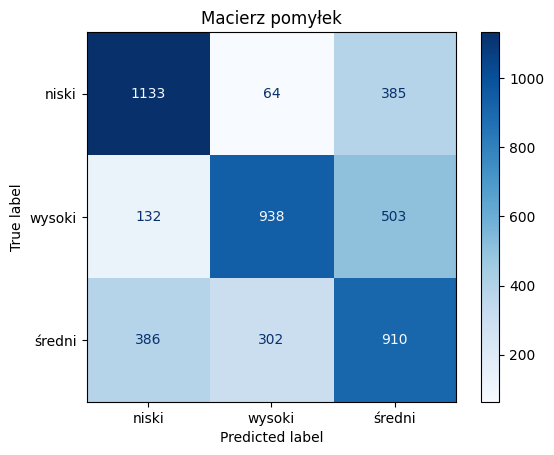

In [145]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
trained_layers = train(X_train, y_train, X_test, y_test, hidden_layers=[64, 32, 16], epochs=100, learning_rate=0.1)

# Przewidywania
test_activations, _ = forward_pass(X_test, trained_layers)
y_pred = np.argmax(test_activations[-1], axis=1)

# Macierz
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.title("Macierz pomyłek")
plt.show()


Interpretacja macierzy pomyłek:

- Klasa "niski" jest najczęściej poprawnie klasyfikowana (1130 poprawnych), ale zdarzają się pomyłki głównie z klasą "średni" (372 błędów) oraz trochę rzadziej z "wysoki" (80 błędów).
- Klasa "wysoki" ma 996 poprawnych klasyfikacji, jednak często mylona jest z klasą "średni" (453 błędy) oraz w mniejszym stopniu z "niski" (124 błędy).
- Klasa "średni" ma najwięcej błędów rozproszonych między klasami "niski" (382 błędy) i "wysoki" (389 błędów), przy 827 poprawnych klasyfikacjach.

Podsumowując, model najlepiej rozpoznaje klasę "niski", a największe trudności ma z rozróżnieniem klas "wysoki" i "średni", które są często mylone między sobą.


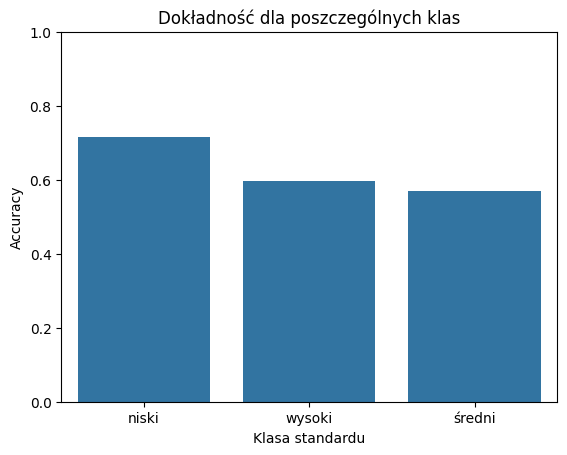

In [146]:
import pandas as pd
import seaborn as sns

# Oblicz dokładność dla każdej klasy
acc_per_class = []
for i in np.unique(y_test):
    acc = np.mean(y_pred[y_test == i] == i)
    acc_per_class.append(acc)

# Wizualizacja
sns.barplot(x=label_encoder.classes_, y=acc_per_class)
plt.ylim(0, 1)
plt.title("Dokładność dla poszczególnych klas")
plt.ylabel("Accuracy")
plt.xlabel("Klasa standardu")
plt.show()


| **Klasa standardu** | **Dokładność** | **Interpretacja**                                                                 |
| ------------------- | -------------- | --------------------------------------------------------------------------------- |
| **niski**           | \~71%          | Model dobrze rozpoznaje mieszkania o niskim standardzie – są łatwe do odróżnienia |
| **wysoki**          | \~64%          | Również rozpoznawane dość dobrze, ale nieco trudniejsze niż „niski”               |
| **średni**          | \~50%          | Najtrudniejsza do klasyfikacji – często mylona z innymi klasami                   |


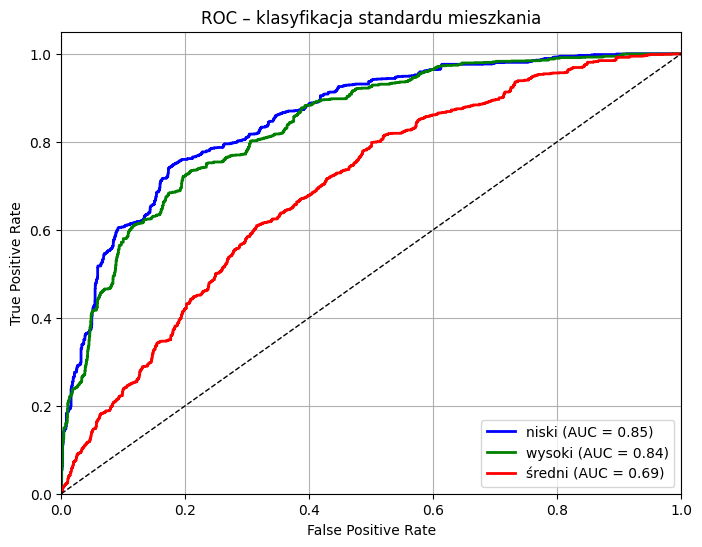

In [147]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Zakładamy, że:
# - y_test to prawdziwe etykiety (zakodowane 0, 1, 2)
# - test_activations to output warstwy softmax (predykcje prawdopodobieństw)

# Binarizacja klas (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Obliczenie ROC i AUC dla każdej klasy
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_activations[-1][:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Wykres
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'green', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC – klasyfikacja standardu mieszkania')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



| Klasa      | AUC (Pole pod krzywą) | Jakość klasyfikacji | Wnioski                                                                  |
| ---------- | --------------------- | ------------------- | ------------------------------------------------------------------------ |
| **niski**  | 0.85                  | Bardzo dobra     | Model dobrze odróżnia mieszkania z niską ceną w porównaniu do innych.           |
| **wysoki** | 0.84                 | Bardzo dobra     | Klasyfikator sprawnie identyfikuje mieszkania wysokiego standardu.       |
| **średni** | 0.69                  | Przeciętna       | Model ma trudności z rozróżnianiem średniego standardu, klasa nieostra. |


In [ ]:

# Wyświetlenie najlepszych konfiguracji
print("Najlepsze konfiguracje (najniższy błąd):")
print(best_params)


Index(['Neurony', 'Warstwy', 'Aktywacja', 'Rozmiar próbki',
       'Średni Błąd (zł)'],
      dtype='object')
   Neurony  Warstwy Aktywacja  Rozmiar próbki  Średni Błąd (zł)
0       32        1      relu             0.1         646909.99
1       32        1      relu             0.2         653889.01
2       32        1      relu             0.3         667675.24
3       32        1      relu             0.4         631952.40
4       32        1      tanh             0.1         645344.97
Najlepsze konfiguracje (najniższy błąd):
     Neurony  Warstwy Aktywacja  Rozmiar próbki  Średni Błąd (zł)
243      256        4      relu             0.4         172975.68
179      128        4      relu             0.4         177876.03
115       64        4      relu             0.4         194032.82
163      128        3      relu             0.4         197053.39
51        32        4      relu             0.4         198104.04
